In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("ca95.csv.gz",compression='gzip')
df.authorship.value_counts().head(30)

PER CURIAM      9456
TJOFLAT          918
KRAVITCH         686
HILL             602
HATCHETT         582
CARNES           529
ANDERSON         527
JOHNSON          475
BIRCH            474
CLARK            464
FAY              460
MARCUS           424
BARKETT          416
RONEY            399
EDMONDSON        376
DUBINA           372
HULL             348
WILSON           321
BLACK            297
COX              296
GODBOLD          290
MARTIN           247
VANCE            240
PRYOR            234
BY THE COURT     217
TUTTLE           216
NEWMAN           215
SPEER            151
HENDERSON        145
JORDAN           122
Name: authorship, dtype: int64

In [3]:
df.authorship = df.authorship.str.upper()
names = []
for i in df.authorship.value_counts().head(100).index:
    if i != 'PER CURIAM' and i != 'PER CURIAM:':
        names.append(i)
copy = pd.DataFrame()
temp = df[df.word_count > 50]
for name in names:
    copy = copy.append(temp[temp.authorship == name])
copy.date_standard = copy.date_standard.str[:4]
copy.date_standard = copy.date_standard.astype(int)
copy = copy.drop(columns=['opinion_type','opinion_id','word_count','authors','dc_source','judges_refined'])
copy

,dc_identifier,opinion,authorship,date_standard
13,3S4X-0PS0-003B-P48S-00000-00,"TJOFLAT, Chief Judge:\n\nSection 2(a) of the V...",TJOFLAT,1994
56,42KM-78G0-0038-X0X6-00000-00,"TJOFLAT, Circuit Judge:\n\nThis appeal represe...",TJOFLAT,2001
63,43RT-KVP0-0038-X4FH-00000-00,"TJOFLAT, Circuit Judge:\n\nStripped to its ess...",TJOFLAT,2001
65,44R9-T0N0-0038-X4N5-00000-00,"TJOFLAT, Circuit Judge:\n\nIn this criminal ca...",TJOFLAT,2001
73,5K6Y-C2B1-F04K-X0XJ-00000-00,"TJOFLAT, Circuit Judge:\n\nThis appeal concern...",TJOFLAT,2016
...,...,...,...,...
19382,4CX7-9T60-0038-X1M8-00000-00,"JORDAN, District Judge:\n\nFollowing a two-wee...",JORDAN,2004
21132,5947-B4C1-F04K-X04G-00000-00,"JORDAN, Circuit Judge, dissenting:\n\nMy view ...",JORDAN,2013
22687,4JS2-RMR0-0038-X4B1-00000-00,"JORDAN, District Judge:\n\nSamir M. Alim petit...",JORDAN,2006
23378,4N16-4FC0-0038-X4YV-00000-00,"JORDAN, District Judge, specially concurring:\...",JORDAN,2007


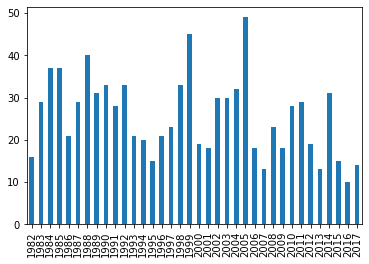

In [4]:
copy[copy.authorship == names[0]].date_standard.value_counts().sort_index().plot(kind='bar')

In [5]:
copy.opinion = copy.opinion.str.replace('Senior Circuit Judge','')
copy.opinion = copy.opinion.str.replace('Senior Circuit Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Senior District Judge','')
copy.opinion = copy.opinion.str.replace('Senior District Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Circuit Judges','')
copy.opinion = copy.opinion.str.replace('CIRCUIT JUDGES','')
copy.opinion = copy.opinion.str.replace('District Judges','')
copy.opinion = copy.opinion.str.replace('District Judges'.upper(),'')
copy.opinion = copy.opinion.str.replace('District Judge','')
copy.opinion = copy.opinion.str.replace('District Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Circuit Judge','')
copy.opinion = copy.opinion.str.replace('CIRCUIT JUDGE','')
copy.opinion = copy.opinion.str.replace('Circuit Justice','')
copy.opinion = copy.opinion.str.replace('Circuit Justice'.upper(),'')
copy.opinion = copy.opinion.str.replace('D\.J\.','')
copy.opinion = copy.opinion.str.replace('D\. J\.','')
copy.opinion = copy.opinion.str.replace('C\.J\.','')
copy.opinion = copy.opinion.str.replace('C\. J\.','')
copy.opinion = copy.opinion.str.replace('Senior Judge','')
copy.opinion = copy.opinion.str.replace('Senior Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Associate Justice','')
copy.opinion = copy.opinion.str.replace('Associate Justice'.upper(),'')
copy.opinion = copy.opinion.str.replace('Chief Judge','')
copy.opinion = copy.opinion.str.replace('Chief Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Judge','')
copy.opinion = copy.opinion.str.replace('Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('HONORABLE','')

for name in names:
    copy.opinion = copy.opinion.str.replace(name.upper(),'')
    copy.opinion = copy.opinion.str.replace(name,'')
    copy.opinion = copy.opinion.str.replace(name[:1].upper()+name[1:].lower(),'')





copy.opinion = copy.opinion.str.replace('JAMES',' ')
copy.opinion = copy.opinion.str.replace('James',' ')
copy.opinion = copy.opinion.str.replace('ALBERT',' ')
copy.opinion = copy.opinion.str.replace('Albert',' ')
copy.opinion = copy.opinion.str.replace('\n',' ')

In [6]:
copy.opinion = copy.opinion.str.replace('\\\'','')
copy.opinion = copy.opinion.str.replace('(','')
copy.opinion = copy.opinion.str.replace(')','')
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\w\.", "", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\.\s", " ", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\.\s", " ", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\,", ",", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\d+", "", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"-", "", x))
copy.opinion = copy.opinion.str.replace('S\.C\.','')
copy.opinion = copy.opinion.str.replace('Ct\.','Ct')
copy.opinion = copy.opinion.str.replace('Ed\.','Ed')
copy.opinion = copy.opinion.str.replace('Dec\.','Dec')
copy.opinion = copy.opinion.str.replace(' No\.',' No')
copy.opinion = copy.opinion.str.replace(' pt\.',' pt')
copy.opinion = copy.opinion.str.replace(' Rep\.',' Rep')
copy.opinion = copy.opinion.str.replace(' Tr\.',' Tr')
copy.opinion = copy.opinion.str.replace(' Arg\.',' Arg')
copy.opinion = copy.opinion.str.replace(' Nev\.',' Nev')
copy.opinion = copy.opinion.str.replace(' Rev\.',' Rev')
copy.opinion = copy.opinion.str.replace(' Stat\.',' Stat')
copy.opinion = copy.opinion.str.replace(' Cent\.',' Cent')
copy.opinion = copy.opinion.str.replace(' Ore\.',' Ore')
copy.opinion = copy.opinion.str.replace(' Co\.',' Co')
copy.opinion = copy.opinion.str.replace(' Ins\.',' Ins')
copy.opinion = copy.opinion.str.replace('S\.','')
copy.opinion = copy.opinion.str.replace('Cf\.','Cf')
copy.opinion = copy.opinion.str.replace('Id\.','Id')
copy.opinion = copy.opinion.str.replace(' ,',',')
copy.opinion = copy.opinion.str.replace(' \.','.')
copy.opinion = copy.opinion.str.replace('§','')
copy.opinion = copy.opinion.str.replace('$','')
copy.opinion = copy.opinion.str.replace('\.\.','.')
copy.opinion = copy.opinion.str.replace('\.\.','.')
copy.opinion = copy.opinion.str.replace(',,',',')
copy.opinion = copy.opinion.str.replace(',,',',')
copy.opinion = copy.opinion.str.replace(',\.',',')
copy.opinion = copy.opinion.str.replace('"',' ')
copy.opinion = copy.opinion.str.replace('II','')
copy.opinion = copy.opinion.str.replace('III','')
copy.opinion = copy.opinion.str.replace('  ',' ')

In [7]:
# Prints the first 200 characters of the first 10 cleaned opinion texts of a given judge.
judge = 0
print(names[judge]+'\n')
for x in range(10):
    print(copy.opinion[copy.loc[copy.authorship==names[judge]].index[x]][:200]+'\n\n')

TJOFLAT

, : Section a of the Voting Rights Act,  , states that no voting qualification or prerequisite to voting, or standard, practice, or procedure shall be imposed or applied by any State or political subd


, : This appeal represents the latestand we hope finalchapter in a protracted RICO prosecution which has already commanded the attention of four panels of this court. See United States Kramer, d th Ci


, : Stripped to its essentials, this is a simple medical malpractice case. It was brought, however, as a multicount RICO prosecution. Suspecting that the claims in the complaint lacked factual bases, 


, : In this criminal case, the question presented is whether the sentencing guidelines authorize a sentencer to penalize the defendant for refusing to cooperate with the government in a criminal inves


, : This appeal concerns a settlement agreement made contingent on vacating certain orders of the District Court. After being moved to do so under Rule b of the Federal Rules of C

In [8]:
#get rough estimate for total number of top 10 authors in all 3 splits
top = 2000
bot = 1970
split1 = pd.DataFrame()
for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split1 = split1.append(temp[temp.date_standard<=bot])
split2 = pd.DataFrame()
for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
split3 = pd.DataFrame()
for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split3 = split3.append(temp[temp.date_standard>=top])

for i in range(3):
    totalNum = split1.shape[0]+split2.shape[0]+split3.shape[0]
    print('totalNum = '+str(totalNum))
    print(split1.shape)
    print(split2.shape)
    print(split3.shape)    

    #initialize the splits so we can iterate over them
    top = 2020
    bot = 1800
    split1 = pd.DataFrame()
    for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split1 = split1.append(temp[temp.date_standard<=bot])
    split2 = pd.DataFrame()
    for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
    split3 = pd.DataFrame()
    for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split3 = split3.append(temp[temp.date_standard>=top])
    
    
    
    
    #loop to iterate 
    while split1.shape[0] < totalNum/3:
        bot += 1
        split1 = pd.DataFrame()
        for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
            temp = copy[copy.authorship == x]
            split1 = split1.append(temp[temp.date_standard<=bot])    
    while split3.shape[0] < totalNum/3:
        top -= 1
        split3 = pd.DataFrame()
        for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
            temp = copy[copy.authorship == x]
            split3 = split3.append(temp[temp.date_standard>=top])
    split2 = pd.DataFrame()
    for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
    

    print(split1.shape)
    print(split2.shape)
    print(split3.shape)
    print('top = '+str(top)+' bot = '+str(bot))

totalNum = 7659
(367, 4)
(4324, 4)
(2968, 4)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(2672, 4)
(2379, 4)
(2656, 4)
top = 2002 bot = 1989
totalNum = 7707
(2672, 4)
(2379, 4)
(2656, 4)
(2672, 4)
(2379, 4)
(2656, 4)
top = 2002 bot = 1989
totalNum = 7707
(2672, 4)
(2379, 4)
(2656, 4)
(2672, 4)
(2379, 4)
(2656, 4)
top = 2002 bot = 1989


# Bag of Words approach

## Split 1

In [9]:
split1.authorship.value_counts()

HILL        357
JOHNSON     319
KRAVITCH    303
HATCHETT    275
CLARK       262
RONEY       259
TJOFLAT     240
VANCE       232
NEWMAN      215
GODBOLD     210
Name: authorship, dtype: int64

In [10]:
print('Number of Datapoints: ', split1.shape[0])

Number of Datapoints:  2672


In [11]:
split1names = split1.authorship.unique()

for index, name in enumerate(split1names):
    split1.authorship = split1.authorship.str.replace(name, str(index))
split1.authorship = split1.authorship.astype(int)

In [12]:
vectorizer1 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM1 = vectorizer1.fit_transform(split1.opinion)
#print(bowM1.toarray().shape)
#print(vectorizer1.get_feature_names())

In [13]:
X1 = pd.DataFrame.sparse.from_spmatrix(bowM1)
X1 = X1.sparse.to_dense()

In [14]:
for x in range(0,len(X1.columns)):
    mean = X1.iloc[:,x].mean()
    std = X1.iloc[:,x].std()
    X1.iloc[:,x] = (X1.iloc[:,x] - mean)/std

In [15]:
Y1 = split1.authorship.to_frame().reset_index().drop(columns=['index'])

X1_Training, X1_Testing, y1_Training, y1_Testing = train_test_split(X1, Y1, test_size=0.2, random_state=1234)

In [16]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_Training, y1_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X1_train), np.array(y1_train))
    values = classifier.predict_proba(np.array(X1_test))
    
    correct = 0
    counter = 0
    for k in range(0,y1_test.size):
        if np.amax(values[k]) == values[k][int(y1_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.5654205607476636
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5957943925233645
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5957943925233645
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5490654205607477
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5350467289719626
Accuracy:  0.5682242990654206  +/-  0.024478132436838888


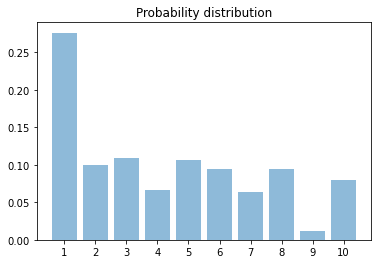

Accuracy:  0.5457943925233645


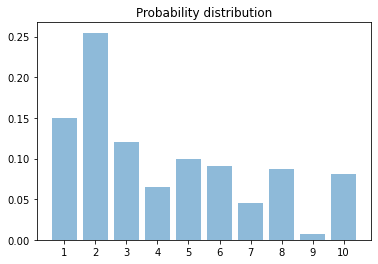

Accuracy:  0.5457943925233645


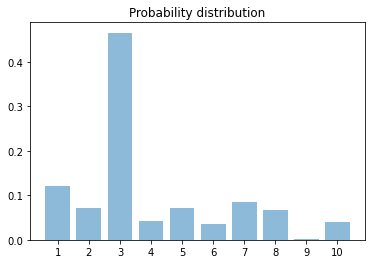

Accuracy:  0.5457943925233645


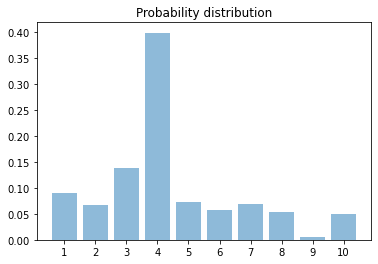

Accuracy:  0.5457943925233645


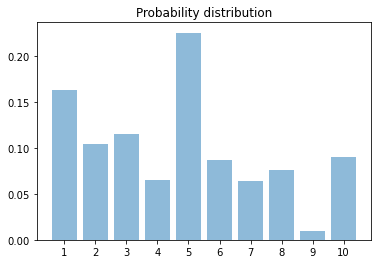

Accuracy:  0.5457943925233645


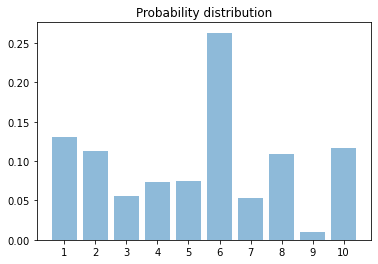

Accuracy:  0.5457943925233645


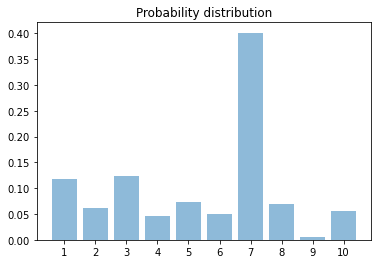

Accuracy:  0.5457943925233645


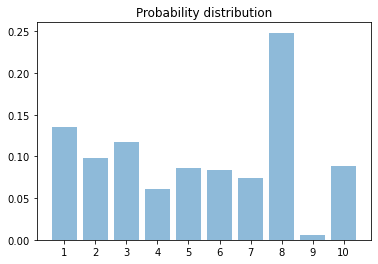

Accuracy:  0.5457943925233645


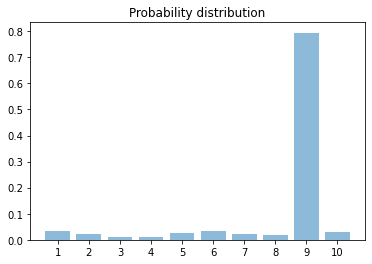

Accuracy:  0.5457943925233645


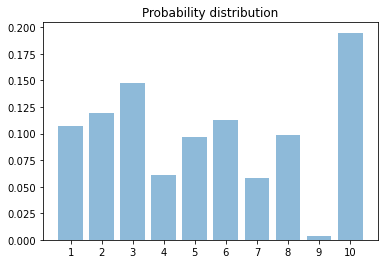

Accuracy:  0.5457943925233645


In [17]:
values1 = classifier.predict_proba(np.array(X1_Testing))
data1 = pd.DataFrame(data=values1)
data1['Y'] = y1_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data1.to_csv('95_split1_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data1.iterrows():
        if(row['Y'] == l):
            for k in range(0,10):
                probs[k] += row[k]
            count += 1
    
    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()
    
    correct = 0
    counter = 0
    for k in range(0,y1_Testing.size):
        if np.amax(values1[k]) == values1[k][int(y1_Testing.iloc[k])]:
            correct += 1
        counter += 1
        
    print('Accuracy: ',correct/counter)

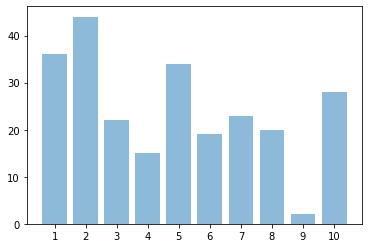

[36, 44, 22, 15, 34, 19, 23, 20, 2, 28]


In [18]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data1.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

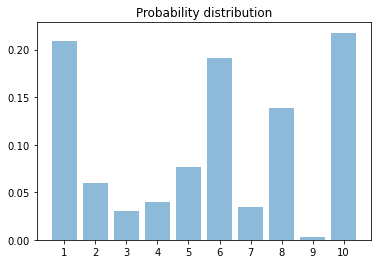

In [19]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values1[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

## Split 2

In [20]:
split2.authorship.value_counts()

TJOFLAT      309
BIRCH        291
HATCHETT     280
KRAVITCH     273
ANDERSON     244
CARNES       224
EDMONDSON    222
DUBINA       185
FAY          183
CLARK        168
Name: authorship, dtype: int64

In [21]:
print('Number of Datapoints: ', split2.shape[0])

Number of Datapoints:  2379


In [22]:
split2names = split2.authorship.unique()

for index, name in enumerate(split2names):
    split2.authorship = split2.authorship.str.replace(name, str(index))
split2.authorship = split2.authorship.astype(int)

In [23]:
vectorizer2 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM2 = vectorizer2.fit_transform(split2.opinion)
#print(bowM2.toarray().shape)
#print(vectorizer2.get_feature_names())

In [24]:
X2 = pd.DataFrame.sparse.from_spmatrix(bowM2)
X2 = X2.sparse.to_dense()

In [25]:
for x in range(0,len(X2.columns)):
    mean = X2.iloc[:,x].mean()
    std = X2.iloc[:,x].std()
    X2.iloc[:,x] = (X2.iloc[:,x] - mean)/std

In [26]:
Y2 = split2.authorship.to_frame().reset_index().drop(columns=['index'])

X2_Training, X2_Testing, y2_Training, y2_Testing = train_test_split(X2, Y2, test_size=0.2, random_state=1234)

In [27]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_Training, y2_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X2_train), np.array(y2_train))
    values = classifier.predict_proba(np.array(X2_test))
    
    correct = 0
    counter = 0
    for k in range(0,y2_test.size):
        if np.amax(values[k]) == values[k][int(y2_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.6561679790026247
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6640419947506562
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6509186351706037
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6404199475065617
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6167979002624672
Accuracy:  0.6456692913385826  +/-  0.016348988453960572


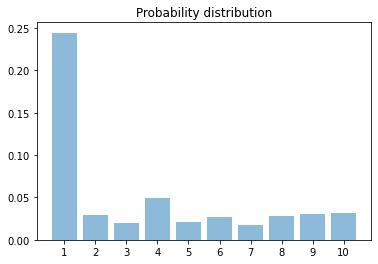

Accuracy:  0.6365546218487395


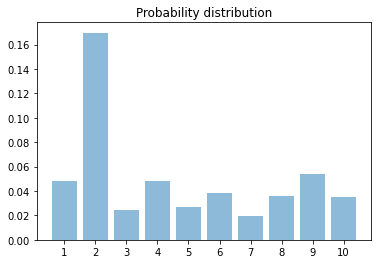

Accuracy:  0.6365546218487395


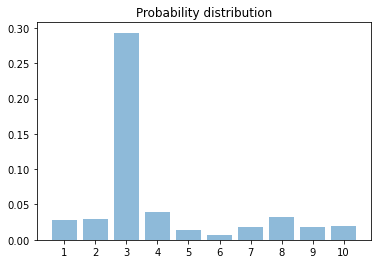

Accuracy:  0.6365546218487395


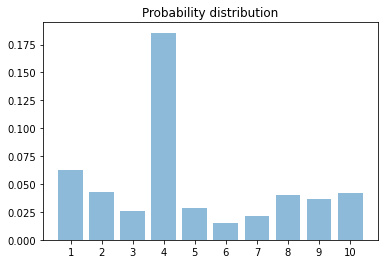

Accuracy:  0.6365546218487395


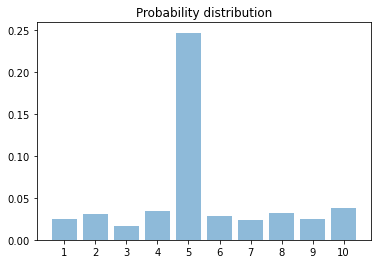

Accuracy:  0.6365546218487395


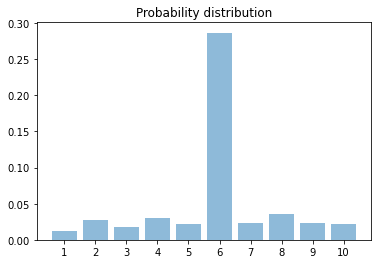

Accuracy:  0.6365546218487395


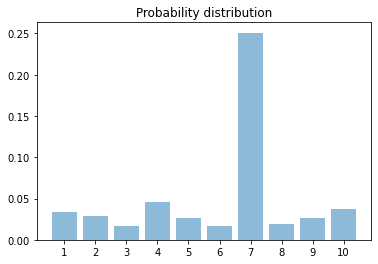

Accuracy:  0.6365546218487395


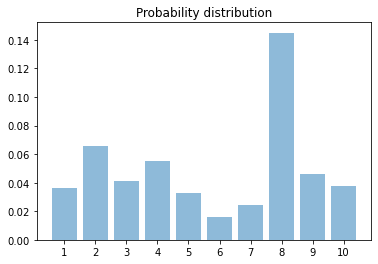

Accuracy:  0.6365546218487395


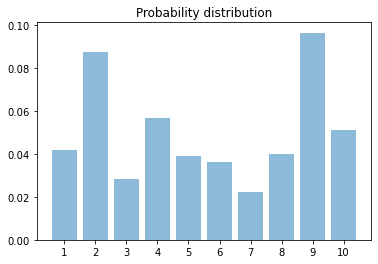

Accuracy:  0.6365546218487395


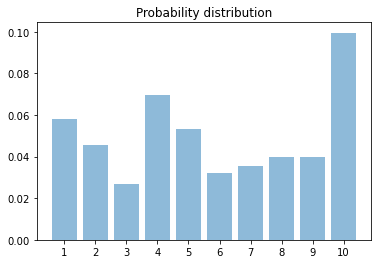

Accuracy:  0.6365546218487395


In [28]:
values2 = classifier.predict_proba(np.array(X2_Testing))
data2 = pd.DataFrame(data=values2)
data2['Y'] = y2_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data2.to_csv('95_split2_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data2.iterrows():
        if(row['Y'] == l):
            count += 1
            for k in range(0,10):
                probs[k] += row[k]
            count += 1

    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()
    
    correct = 0
    counter = 0
    for k in range(0,y2_Testing.size):
        if np.amax(values2[k]) == values2[k][int(y2_Testing.iloc[k])]:
            correct += 1
        counter += 1
        
    print('Accuracy: ',correct/counter)

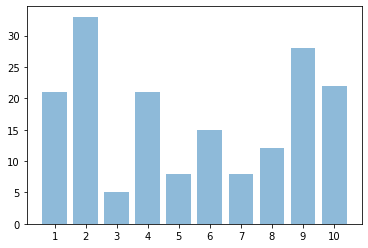

[21, 33, 5, 21, 8, 15, 8, 12, 28, 22]


In [29]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data2.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

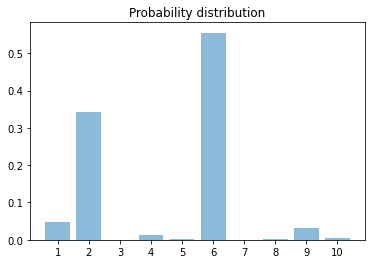

In [30]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values2[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

## Split 3

In [31]:
split3.authorship.value_counts()

TJOFLAT    372
MARCUS     351
CARNES     304
HULL       281
WILSON     280
MARTIN     246
BARKETT    239
PRYOR      234
DUBINA     184
BLACK      165
Name: authorship, dtype: int64

In [32]:
print('Number of Datapoints: ', split3.shape[0])

Number of Datapoints:  2656


In [33]:
split3names = split3.authorship.unique()

for index, name in enumerate(split3names):
    split3.authorship = split3.authorship.str.replace(name, str(index))
split3.authorship = split3.authorship.astype(int)

In [34]:
vectorizer3 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM3 = vectorizer3.fit_transform(split3.opinion)
#print(bowM3.toarray().shape)
#print(vectorizer3.get_feature_names())

In [35]:
X3 = pd.DataFrame.sparse.from_spmatrix(bowM3)
X3 = X3.sparse.to_dense()

In [36]:
for x in range(0,len(X3.columns)):
    mean = X3.iloc[:,x].mean()
    std = X3.iloc[:,x].std()
    X3.iloc[:,x] = (X3.iloc[:,x] - mean)/std

In [37]:
Y3 = split3.authorship.to_frame().reset_index().drop(columns=['index'])

X3_Training, X3_Testing, y3_Training, y3_Testing = train_test_split(X3, Y3, test_size=0.2, random_state=1234)

In [38]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X3_train, X3_test, y3_train, y3_test = train_test_split(X3_Training, y3_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X3_train), np.array(y3_train))
    values = classifier.predict_proba(np.array(X3_test))
    
    correct = 0
    counter = 0
    for k in range(0,y3_test.size):
        if np.amax(values[k]) == values[k][int(y3_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.6776470588235294
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6847058823529412
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7152941176470589
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6988235294117647
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6964705882352941
Accuracy:  0.6945882352941176  +/-  0.01292191079317271


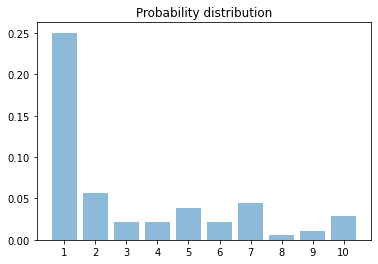

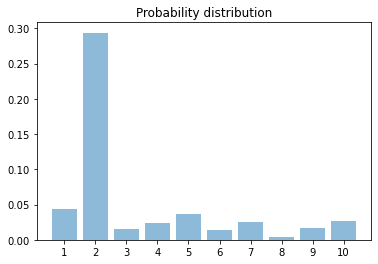

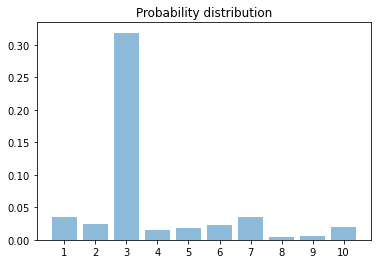

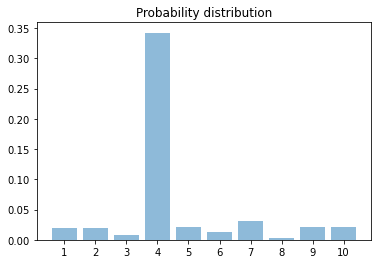

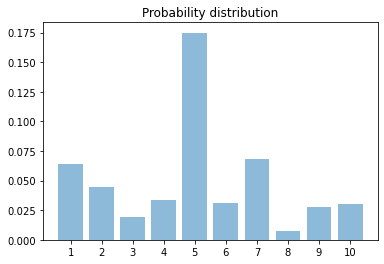

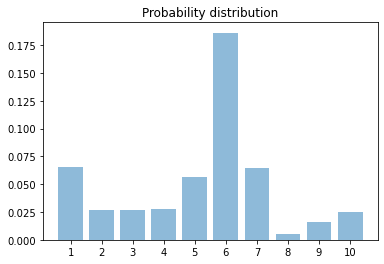

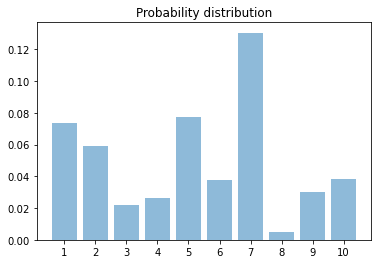

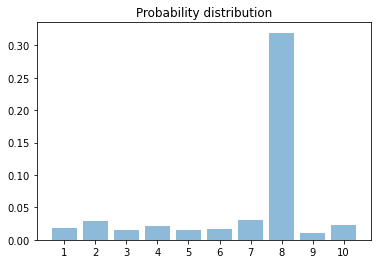

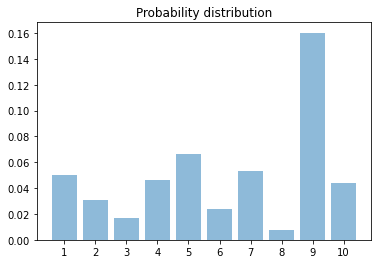

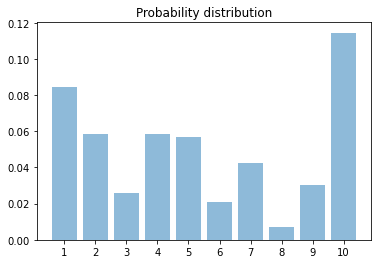

In [39]:
values3 = classifier.predict_proba(np.array(X3_Testing))
data3 = pd.DataFrame(data=values3)
data3['Y'] = y3_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data3.to_csv('95_split3_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data3.iterrows():
        if(row['Y'] == l):
            count += 1
            for k in range(0,10):
                probs[k] += row[k]
            count += 1

    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()

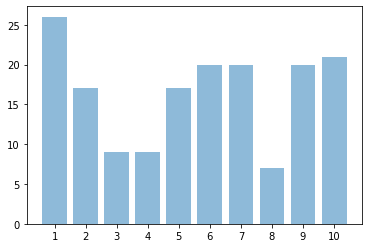

[26, 17, 9, 9, 17, 20, 20, 7, 20, 21]


In [40]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data3.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

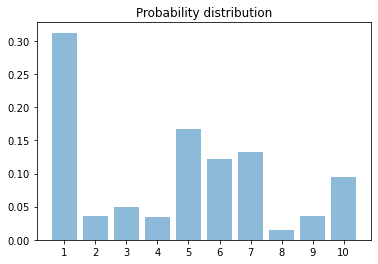

In [41]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values3[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()